In [1]:
import pandas as pd
import nltk
import re

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.stem.snowball import SnowballStemmer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Wadu\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Wadu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Wadu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
dataset = pd.read_csv(r'D:\Radu\fac\master\PML\Restanta\tweet_emotions.csv')
lista_sentimente_sterse = ['anger', 'boredom', 'enthusiasm', 'hate','empty','relief','fun','surprise']

df = dataset[~dataset['sentiment'].isin(lista_sentimente_sterse)]

In [4]:
distributie_clase_sentimente = df['sentiment'].value_counts()
print(distributie_clase_sentimente)

sentiment
neutral      8638
worry        8459
happiness    5209
sadness      5165
love         3842
Name: count, dtype: int64


In [5]:

from nltk.stem import WordNetLemmatizer

stemmer = SnowballStemmer('english')

def normalizare(text):
    # eliminare URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # eliminare user @ references and '#' 
    text = re.sub(r'\@\w+|\#','', text)

    # eliminare semne du punctuatie
    text = re.sub(r'[^\w\s]', '', text)

    # text mic
    text = text.lower()

    word_tokens = word_tokenize(text)
    
    # Stemming
    stemmed_tokens = [stemmer.stem(token) for token in word_tokens]
    
    filtered_text = [word for word in stemmed_tokens]
    
    return " ".join(filtered_text)

amaz i manag to get work done visit for more info product


In [6]:
X = df['content'].apply(normalizare)
Y = df['sentiment']

# maparea sentimentelor
id_sentimente = pd.factorize(df['sentiment'])[0]

# convertire intr un numpy array
id_sentimente_array = np.array(id_sentimente)

Y = id_sentimente_array

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [8]:
tf_idf = TfidfVectorizer(ngram_range=(1,1))

X_train_tfidf = tf_idf.fit_transform(X_train)
X_test_tfidf = tf_idf.transform(X_test)

In [25]:
count_vect = CountVectorizer(ngram_range=(1,1))

X_train_counts = count_vect.fit_transform(X_train)
X_test_counts = count_vect.transform(X_test)

In [9]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# initializarea modelului
model_dummy = DummyClassifier(strategy="uniform")

# Fit 
model_dummy.fit(X_train, y_train)

# Predict
dummy_pred = model_dummy.predict(X_test)

# Calcularea Baseline ului
acc = accuracy_score(y_test, dummy_pred)
print("Acuratete baseline:", acc)
print("Classification Report:\n", classification_report(y_test, dummy_pred))

Acuratete baseline: 0.1994251955931662
Classification Report:
               precision    recall  f1-score   support

           0       0.19      0.21      0.20      1107
           1       0.25      0.19      0.22      1683
           2       0.27      0.20      0.23      1630
           3       0.13      0.21      0.16       809
           4       0.16      0.19      0.17      1034

    accuracy                           0.20      6263
   macro avg       0.20      0.20      0.20      6263
weighted avg       0.22      0.20      0.20      6263



In [10]:
from sklearn.cluster import KMeans

#numarul de clustere 
k = 250

kmeans = KMeans(
    n_clusters=k,
    init= 'random',
    algorithm='lloyd'
)

#fit
kmeans.fit(X_train_tfidf)

#predict
clusters_pred = kmeans.predict(X_test_tfidf)


c:\Users\Wadu\anaconda3\envs\pachet\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [21]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd

# Definirea parametrilor
rezultate = []
numar_clusterere = [13, 20, 30,60,100,150,200,250]
init_valori = ['k-means++','random']
algoritm = ['lloyd', 'elkan']

cel_mai_bun_scor = -1
cei_mai_buni_parametri = {}

for n_clusters in numar_clusterere:
    for init in init_valori:
        for x in algoritm:
                    # Initializare kmeans
                    kmeans = KMeans(n_clusters=n_clusters, init=init,algorithm=x,n_init='auto')
                    
                    # Fit KMeans si calculare silhouette score
                    kmeans.fit(X_train_tfidf)
                    score = silhouette_score(X_train_tfidf, kmeans.labels_)
                    print(f"Parameters: n_clusters={n_clusters}, init='{init}', algoritm ='{x}' ")
                    print(f"Silhouette Score: {score}\n")
                    
                    #stocam rezultatele
                    rezultate.append({
                        'n_clusters': n_clusters,
                        'init': init,
                        'algoritm': x,
                        'silhouette_score': score
                    })
                    if score > cel_mai_bun_scor:
                        #actualizam cel mai bun scor si cei mai buni parametri
                        cel_mai_bun_scor = score
                        cei_mai_buni_parametri = {'n_clusters': n_clusters, 'init': init, 'algoritm':x }

# Convertim lista in DataFrame
results_df = pd.DataFrame(rezultate)
# Afisarea parametrilor
print("Best parameters:", cei_mai_buni_parametri )
print("Best silhouette score:", cel_mai_bun_scor)


Parameters: n_clusters=13, init='k-means++', algoritm ='lloyd' 
Silhouette Score: 0.010031439337242463

Parameters: n_clusters=13, init='k-means++', algoritm ='elkan' 
Silhouette Score: 0.010340895076326004

Parameters: n_clusters=13, init='random', algoritm ='lloyd' 
Silhouette Score: 0.009910535896865172

Parameters: n_clusters=13, init='random', algoritm ='elkan' 
Silhouette Score: 0.010315341955203098

Parameters: n_clusters=20, init='k-means++', algoritm ='lloyd' 
Silhouette Score: -0.030392300853320217

Parameters: n_clusters=20, init='k-means++', algoritm ='elkan' 
Silhouette Score: 0.011165317816404815

Parameters: n_clusters=20, init='random', algoritm ='lloyd' 
Silhouette Score: 0.012095479236497344

Parameters: n_clusters=20, init='random', algoritm ='elkan' 
Silhouette Score: 0.01226427054312232

Parameters: n_clusters=30, init='k-means++', algoritm ='lloyd' 
Silhouette Score: 0.012377934554798433

Parameters: n_clusters=30, init='k-means++', algoritm ='elkan' 
Silhouette S

In [13]:
from statistics import mode

def mapare_clustere(y_predicted, y_actual, n_clusters):
    mapping_dict = {}
    mapped_labels = np.zeros_like(y_predicted) 
    
    #pentru fiecare cluster:
    for i in range(n_clusters):
        #mask pentru fiecare cluster
        cluster_mask = (y_predicted == i)
        #daca exista puncte in cluster, determinam cel mai dominant label si al asignam tuturor punctelor din cluster
        if np.any(cluster_mask):
            label_majoritar = mode(y_actual[cluster_mask])
            print(label_majoritar)
            mapped_labels[cluster_mask] = label_majoritar
            mapping_dict[i] = label_majoritar

    return mapped_labels, mapping_dict

In [14]:
mapped_train, mapping_dict = mapare_clustere(kmeans.labels_, y_train, k)
mapped_test = [mapping_dict[pred] for pred in clusters_pred]

1
2
4
2
3
1
4
4
1
2
1
4
2
2
2
4
2
1
1
4
1
2
3
1
2
2
4
2
1
0
1
1
2
2
2
2
2
2
1
2
1
4
4
1
1
2
1
1
1
2
0
0
2
1
2
1
1
2
2
1
1
2
1
4
1
2
4
2
2
2
4
1
2
1
1
2
3
2
1
1
3
2
1
2
4
1
1
3
1
1
2
1
2
2
2
4
1
4
4
1
1
3
1
1
2
1
1
2
1
2
1
1
2
2
1
2
1
2
1
3
1
2
1
2
2
1
1
2
4
2
2
1
4
0
1
2
2
0
4
4
0
2
1
2
2
2
1
1
0
2
2
1
4
0
2
2
2
4
1
2
1
2
3
2
2
2
4
2
1
2
2
1
1
1
4
1
1
1
1
2
1
2
2
1
0
2
1
1
2
4
1
4
2
2
1
1
2
4
4
2
1
2
2
2
1
1
1
2
1
1
1
2
0
0
1
2
4
2
1
4
2
1
2
0
1
0
1
4
1
1
1
2
3
3
1
2
1
1
2
2
0
2
4
1
1
1
1
2
2
4


In [15]:
np.unique(mapped_train, return_counts= True)

(array([0, 1, 2, 3, 4]),
 array([ 1161, 11160,  9600,  1057,  2072], dtype=int64))

In [16]:
from sklearn.metrics import classification_report

print("Report:\n", classification_report(y_test,mapped_test))

Report:
               precision    recall  f1-score   support

           0       0.43      0.11      0.17      1107
           1       0.34      0.55      0.42      1683
           2       0.33      0.49      0.39      1630
           3       0.51      0.19      0.27       809
           4       0.40      0.19      0.26      1034

    accuracy                           0.35      6263
   macro avg       0.40      0.30      0.30      6263
weighted avg       0.38      0.35      0.32      6263



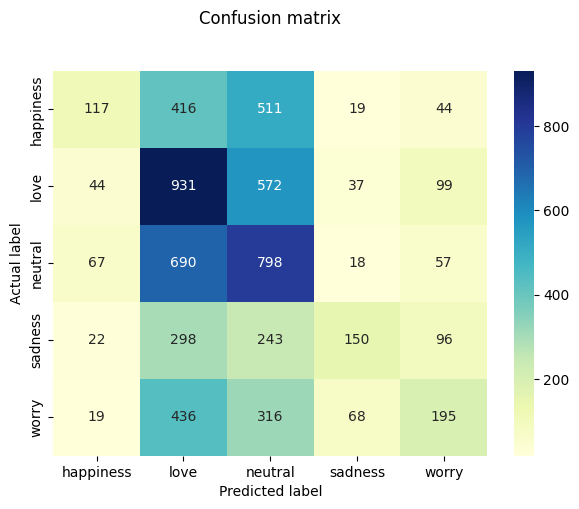

In [17]:
# Import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics

# calcularea matricei de confuzie
cnf_matrix = metrics.confusion_matrix(y_test, mapped_test)

nume_clase = ['happiness', 'love', 'neutral', 'sadness', 'worry']

# creare heatmap
plt.figure(figsize=(7, 5)) 
sns.heatmap(cnf_matrix, annot=True, cmap="YlGnBu", fmt='g', 
            xticklabels=nume_clase, yticklabels=nume_clase)
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
plt.show()

c:\Users\Wadu\anaconda3\envs\pachet\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


Silhouette score: 0.3299103830781833


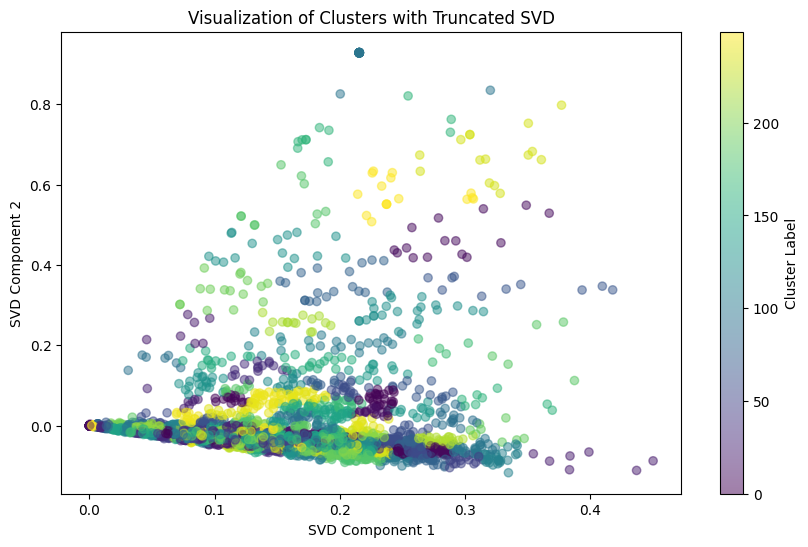

In [19]:

from sklearn.decomposition import TruncatedSVD

#definim svd
svd = TruncatedSVD(n_components=2)  #reducem la 2 componente
X_train_svd = svd.fit_transform(X_train_tfidf)
X_test_svd = svd.transform(X_test_tfidf)


k = 250  
kmeans = KMeans(n_clusters=k, init='random', algorithm='lloyd')
kmeans.fit(X_train_svd) 

# predict
clusters_pred = kmeans.predict(X_test_svd)

# calculare silhouette score
silhouette = silhouette_score(X_train_svd, kmeans.labels_) 
print(f"Silhouette score: {silhouette}")

# Plotare
plt.figure(figsize=(10, 6))
plt.scatter(X_test_svd[:, 0], X_test_svd[:, 1], c=clusters_pred, cmap='viridis', alpha=0.5)
plt.xlabel('SVD Component 1')
plt.ylabel('SVD Component 2')
plt.title('Visualization of Clusters with Truncated SVD')
plt.colorbar(label='Cluster Label')

plt.show()